In [14]:
from torchsig.utils.visualize import (
    MaskClassVisualizer,
    mask_class_to_outline,
    complex_spectrogram_to_magnitude,
)
from torchsig.transforms.target_transforms import DescToMaskClass, DescToListTuple
from torchsig.transforms import Spectrogram, Normalize
from torchsig.utils.writer import DatasetCreator, DatasetLoader
from torchsig.datasets.wideband_sig53 import WidebandSig53
from torchsig.datasets.wideband import WidebandModulationsDataset
from torchsig.transforms.transforms import Compose
from torchsig.datasets import conf
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
cfg = conf.WidebandSig53ImpairedTrainQAConfig
# cfg = conf.WidebandSig53CleanTrainConfig

wideband_ds = WidebandModulationsDataset(
    level=cfg.level,
    num_iq_samples=cfg.num_iq_samples,
    num_samples=cfg.num_samples,
    target_transform=DescToListTuple(),
    seed=cfg.seed,
)

dataset_loader = DatasetLoader(wideband_ds, batch_size=8, num_workers=8, seed=12345678, collate_fn=collate_fn)
creator = DatasetCreator(
    wideband_ds,
    seed=12345678,
    path="wideband_sig53/wideband_sig53_impaired_train",
    loader=dataset_loader,
)
creator.create()

Dataset already exists in wideband_sig53/wideband_sig53_impaired_train. Not regenerating


In [17]:
# cfg = conf.WidebandSig53CleanValQAConfig
cfg = conf.WidebandSig53ImpairedValQAConfig

wideband_ds = WidebandModulationsDataset(
    level=cfg.level,
    num_iq_samples=cfg.num_iq_samples,
    num_samples=cfg.num_samples,
    target_transform=DescToListTuple(),
    seed=cfg.seed,
)

dataset_loader = DatasetLoader(wideband_ds, batch_size=8, num_workers=8, seed=12345678, collate_fn=collate_fn)
creator = DatasetCreator(
    wideband_ds,
    seed=12345678,
    path="wideband_sig53/wideband_sig53_impaired_val",
    loader=dataset_loader,
)
creator.create()

Dataset already exists in wideband_sig53/wideband_sig53_impaired_val. Not regenerating


In [18]:
# Specify WidebandSig53 Options
root = "wideband_sig53/"
train = False
impaired = True
fft_size = 512
num_classes = 53

transform = Compose(
    [
        Spectrogram(nperseg=fft_size, noverlap=0, nfft=fft_size, mode="complex"),
        Normalize(norm=np.inf, flatten=True),
    ]
)

target_transform = Compose(
    [
        DescToMaskClass(num_classes=num_classes, width=fft_size, height=fft_size),
    ]
)

# Instantiate the WidebandSig53 Dataset
wideband_sig53 = WidebandSig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Retrieve a sample and print out information
idx = np.random.randint(len(wideband_sig53))
data, label = wideband_sig53[idx]
print("Dataset length: {}".format(len(wideband_sig53)))
print("Data shape: {}".format(data.shape))
print("Label shape: {}".format(label.shape))

Dataset length: 25
Data shape: (2, 512, 512)
Label shape: (53, 512, 512)


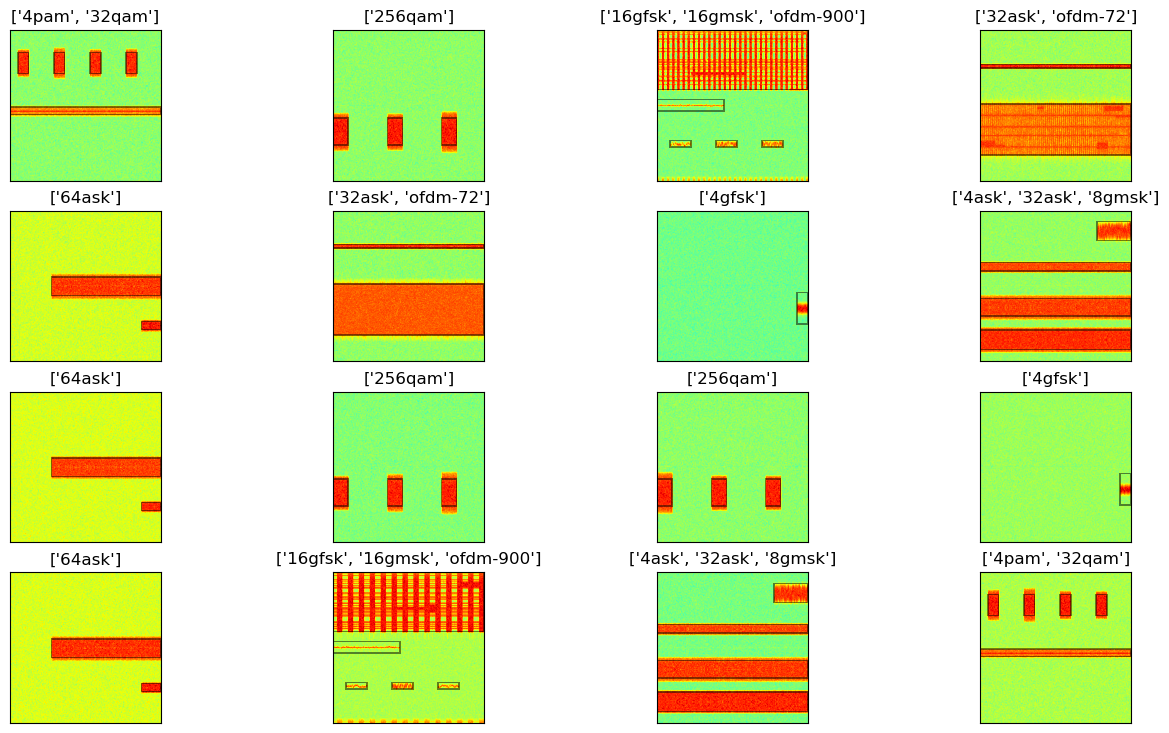

In [20]:
data_loader = DataLoader(
    dataset=wideband_sig53,
    batch_size=16,
    shuffle=True,
)

visualizer = MaskClassVisualizer(
    data_loader=data_loader,
    visualize_transform=complex_spectrogram_to_magnitude,
    visualize_target_transform=mask_class_to_outline,
    class_list=wideband_sig53.modulation_list,
)

for figure in iter(visualizer):
    figure.set_size_inches(16, 9)
    plt.show()
    break

In [6]:
# Re-instantiate the WidebandSig53 Dataset without a target transform and without using the RFData objects
wideband_sig53 = WidebandSig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=None,
)

# Loop through the dataset recording classes and SNRs
class_counter_dict = {
    class_name: 0 for class_name in list(wideband_sig53.modulation_list)
}
num_signals_per_sample = []

for idx in tqdm(range(len(wideband_sig53))):
    data, annotation = wideband_sig53[idx]
    num_signals_per_sample.append(len(annotation))
    for signal_annotation in annotation:
        class_counter_dict[signal_annotation.class_name] += 1

100%|██████████| 25/25 [00:00<00:00, 113.23it/s]


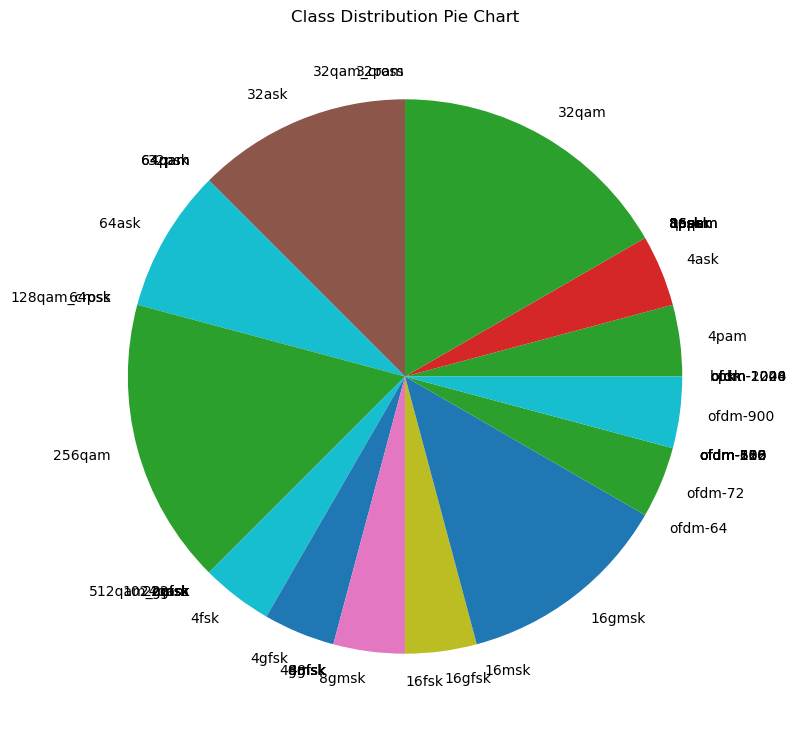

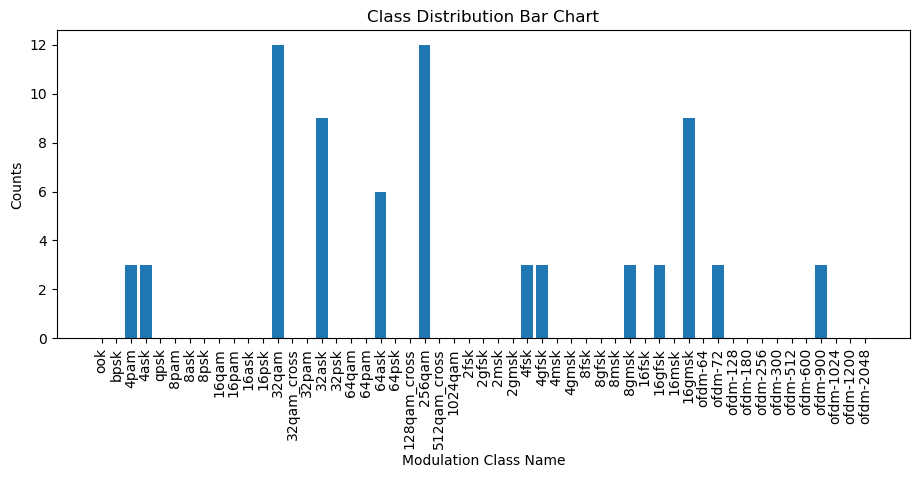

In [7]:
# Plot the distribution of classes
class_names = list(class_counter_dict.keys())
num_classes = list(class_counter_dict.values())

plt.figure(figsize=(9, 9))
plt.pie(num_classes, labels=class_names)
plt.title("Class Distribution Pie Chart")
plt.show()

plt.figure(figsize=(11, 4))
plt.bar(class_names, num_classes)
plt.xticks(rotation=90)
plt.title("Class Distribution Bar Chart")
plt.xlabel("Modulation Class Name")
plt.ylabel("Counts")
plt.show()

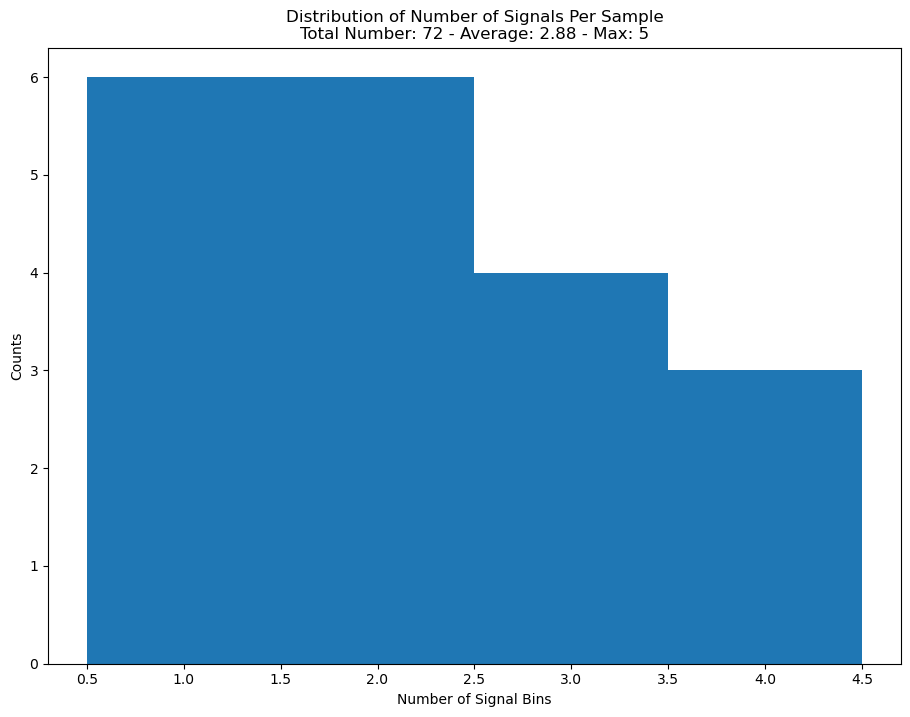

In [8]:
# Plot the distribution of number of signals per sample
plt.figure(figsize=(11, 8))
plt.hist(
    x=num_signals_per_sample, bins=np.arange(1, max(num_signals_per_sample) + 1) - 0.5
)
plt.title(
    "Distribution of Number of Signals Per Sample\nTotal Number: {} - Average: {} - Max: {}".format(
        sum(num_signals_per_sample),
        np.mean(np.asarray(num_signals_per_sample)),
        max(num_signals_per_sample),
    )
)
plt.xlabel("Number of Signal Bins")
plt.ylabel("Counts")
plt.show()

In [9]:
# For additional analysis, reinstantiate the dataset without a target transform, such that the RFDescriptions can be read
wideband_sig53 = WidebandSig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=None,
    target_transform=None,
)

num_samples = len(wideband_sig53)
snrs = []
bandwidths = []
for idx in tqdm(range(num_samples)):
    label = wideband_sig53[idx][1]
    for rf_desc in label:
        snrs.append(rf_desc.snr)
        bandwidths.append(rf_desc.bandwidth)

100%|██████████| 25/25 [00:00<00:00, 427.12it/s]


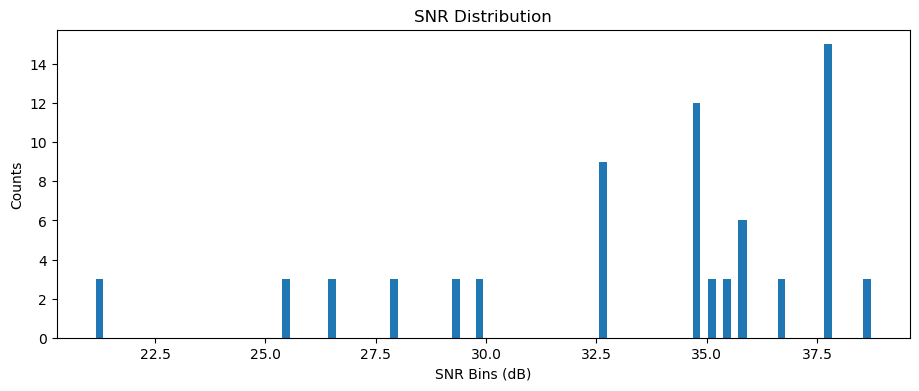

In [10]:
# Plot the distribution of SNR values
plt.figure(figsize=(11, 4))
plt.hist(x=snrs, bins=100)
plt.title("SNR Distribution")
plt.xlabel("SNR Bins (dB)")
plt.ylabel("Counts")
plt.show()

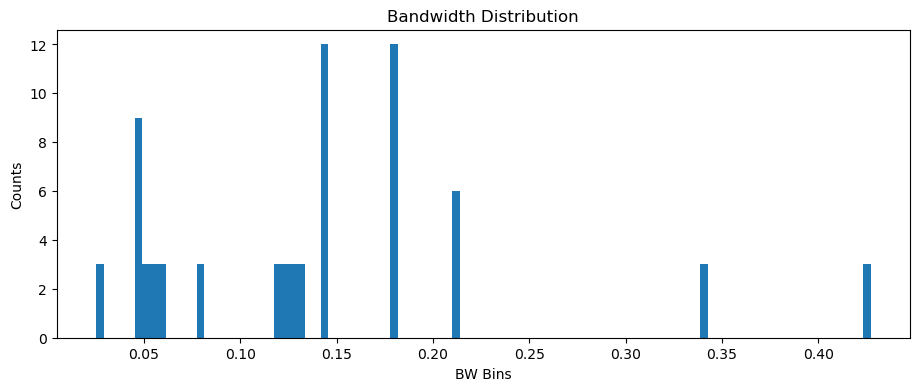

In [11]:
# Plot the distribution of bandwidth values
plt.figure(figsize=(11, 4))
plt.hist(x=bandwidths, bins=100)
plt.title("Bandwidth Distribution")
plt.xlabel("BW Bins")
plt.ylabel("Counts")
plt.show()